<h1 align='center'> Quora Insincere Quetions Prediction <h1>

<h2 align='right'> Euiyoung (Jim) Chung <h2>


## Descriptions:

In this competition you will be predicting whether a question asked on Quora is sincere or not.

An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

Has a non-neutral tone
Has an exaggerated tone to underscore a point about a group of people
Is rhetorical and meant to imply a statement about a group of people
Is disparaging or inflammatory
Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
Makes disparaging attacks/insults against a specific person or group of people
Based on an outlandish premise about a group of people
Disparages against a characteristic that is not fixable and not measurable
Isn't grounded in reality
Based on false information, or contains absurd assumptions
Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers
The training data includes the question that was asked, and whether it was identified as insincere (target = 1). The ground-truth labels contain some amount of noise: they are not guaranteed to be perfect.

Note that the distribution of questions in the dataset should not be taken to be representative of the distribution of questions asked on Quora. This is, in part, because of the combination of sampling procedures and sanitization measures that have been applied to the final dataset.

**Data fields**<br>
qid - unique question identifier<br>
question_text - Quora question text<br>
target - a question labeled "insincere" has a value of 1, otherwise 0<br>


## Table of Contents:

1. Data Import 
2. Exploratory Data Analysis
3. Feature Engineering
4. Trying Multiple Model - Multiple Metrics - accuracy, recall, precision, f1 - based on learning curve I like ~ better.
5. Imbalance in Data - SMOTE
6. Fine-Tuning - f1-weighted, ROC curve, validation curve
7. Insights from the Models -> feature importance
8. Further - Error Analysis

In [7]:
import warnings
warnings.filterwarnings("ignore")

# data wrangling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text handling
from string import punctuation
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string

# ml
from sklearn.model_selection import (train_test_split, RandomizedSearchCV, StratifiedKFold, 
                                        cross_val_score, learning_curve, validation_curve, cross_val_predict)
from sklearn.metrics import (make_scorer, confusion_matrix, accuracy_score,
                            precision_recall_fscore_support, f1_score, classification_report)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Imputer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate

from scipy.sparse import hstack
import tqdm
# DL 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, LSTM, Dense

from functools import partial


plt.style.use('fivethirtyeight')
%matplotlib inline


## Data Import

In [8]:
df = pd.read_csv('train.csv')

In [9]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [10]:
print("rows: {}, columns: {}".format(*df.shape))

rows: 1306122, columns: 3


In [11]:
print("There are {} missing values".format(df.isnull().sum().sum()))

There are 0 missing values


In [12]:
print("Unique targets: {}".format(df['target'].unique()))

Unique targets: [0 1]


In [13]:
# Every ID is unique!
print("Is every ID unique? :", len(df['qid'].unique()) == df.shape[0])

Is every ID unique? : True


<br>

## Exploratory Data Anaylsis 

### First, see the examples of each class

In [14]:
# Examples of insincere texts
pd.options.display.max_colwidth = 100
df[df['target']==1].sample(10)

,qid,question_text,target
892787,aee9a1db3b0ae1011d16,Why are the religious zealots so determined to rule my mind with their guilt and stupid religiou...,1
183178,23cf43ef9c7ac2d25d6f,Why most republicans are old and fat men?,1
178556,22e4a2a2a1c2bbef7bcf,Are Trump supporters culpable/complicit in the decisions Trump makes that adversely affect Ameri...,1
371273,48cb2390bcf8b6754b1e,"In Australia, nobody needs sex which should be abolished! In Australia men and women are totally...",1
201044,274c2bb566d85de888d5,Why do creationists prefer to trust the Bible because it is God's word rather then evidence for ...,1
1025969,c90b20fb93bea50e1cf1,"Despite both tribes being Hindus, why are Nepalese fiercely loyal while most Indians are intrins...",1
1220855,ef47370eb48bf72bc997,Is it okay to kick a child in the stomach to toughen them up?,1
101426,13dccd248782c4269d64,"Why is it that on one hand, feminists feel utterly free to vent their contempt for men and mascu...",1
576726,7100fb93bc515494e4fb,"Given that gaijins think of politeness as fake, should the Japanese be more rude to foreigners?",1
114949,167e867e705e63f81bc0,"If Hindu Gods exist, why didn't they prevent the Muslim/Mughal holocaust of Hindus?",1


In [15]:
# Examples of sincere texts
df[df['target']==0].sample(10)

,qid,question_text,target
1092752,d6266702385da9e4c581,"Suppose you got a license to shoot & kill any 5 people you want, who would you kill?",0
62305,0c3b77c140ea04575519,How do I find which topics I have followed on Quora?,0
229597,2ce89b941e02e4dce682,"How come there are so few psychopaths in the population, yet on Quora there are so many. Why do ...",0
1262259,f75e3bbb1dc90af7a174,How much of an advantage do first generation college applicants get in the admissions process? I...,0
503337,628e0595bccd7997869c,If you score good in CAT when you are on bench then what should I answer the question about my w...,0
58853,0b8c2e6660b4a1d5409a,How do I find the direction from one point on the screen to another in JavaScript?,0
1132161,dde3366ed4fff3276f21,"My thoughts are disorganized, at times I'm distressed emotionally and detached from my feelings ...",0
411330,5099b7cc27f74bed5bf3,How can a shrew be venomous?,0
818359,a059bcaf8488f7f9a61f,Can anyone apply for job at NASA as astronaut if he had completed his graduation from a Russian ...,0
532830,6854967d1fa11010b411,How should I study to get a 9 CGPA in First year BTECH CSE?,0


## 1. Proportion of target class?
## 2. Average lengths of the text of each class?

### Findings

- There is severe imbalance detected in the target class. This imbalance makes the evaluation and training of classifiers far harder. For example, the accuracy metrics is not a precise representation of the performance anymore. A classifier will always lean toward the majority class to get better accuracy.

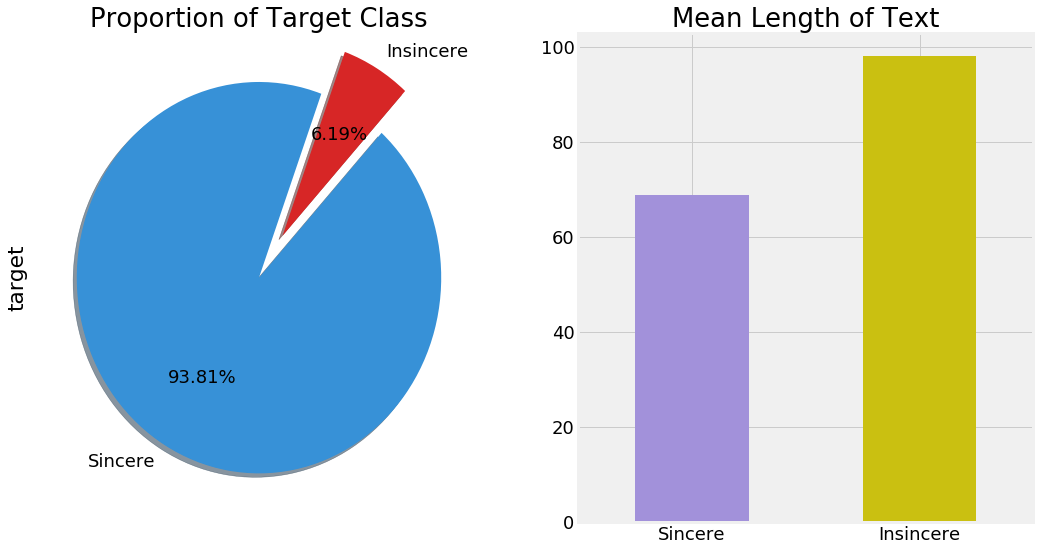

In [16]:
plt.rcParams['font.size'] = 18
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
labels=['Sincere', 'Insincere']
colors = ["#3791D7", "#D72626"]
df["target"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', 
                                             shadow=True, colors=colors, ax=ax1,
                                             labels=labels, startangle=70)

df['text_len'] = df['question_text'].map(len)
text_len_compare = df.groupby(['target'])['text_len'].mean()
text_len_compare.index=labels
text_len_compare.plot.bar(ax=ax2, color=['#A291DA', '#CAC011'], rot=0)

ax1.set_title('Proportion of Target Class')
ax2.set_title('Mean Length of Text')
plt.show()

# Empirical distribution of average text lengths

### Findings

- Mean text lengths could be a good indicator for distinguishing insincere questions from sincere questions. There is clear difference in there distribution and characteristic.

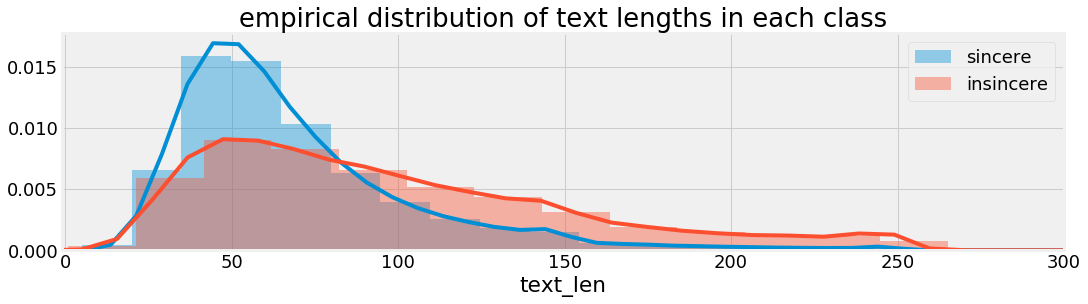

In [17]:
insincere = df[df['target']==1]
sincere = df[df['target']==0]

plt.figure(figsize=(16,4))
sns.distplot(sincere['text_len'], label='sincere')
sns.distplot(insincere['text_len'], label='insincere')

plt.legend()
plt.xlim(-1, 300)
plt.title('empirical distribution of text lengths in each class')
plt.show()

<br>

## What are the most common words in 'sincere' class? - best, good, learn, etc.

In [ ]:
def tokenize(txt):

    def tokenize(s): 
        re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
        return re_tok.sub(r' ', s).split()
    
    token_txt = tokenize(txt)
    stops = set(nltk.corpus.stopwords.words('english'))
    stemmer = nltk.stem.SnowballStemmer('english')
    return [stemmer.stem(token) for token in token_txt if token not in stops]
    
    
def count_word(txt, count_dict):
    clean_txt = tokenize(txt)
    for word in clean_txt:
        count_dict[word] = count_dict.get(word, 0) + 1
    
sincere_word_counter = {}
sincere['question_text'].map(partial(count_word, count_dict=sincere_word_counter))

In [37]:
sorted_sincere_counter = sorted(sincere_word_counter.items(), key = lambda x: x[1], reverse=True)[:50]
printing = [row[0] for row in sorted_sincere_counter]

table_sincere = pd.DataFrame({'rank_1': printing[:10], 'rank_2':printing[10:20], 'rank_3':printing[20:30],
                             'rank_4':printing[30:40], 'rank_5':printing[40:50]})
table_sincere

,rank_1,rank_2,rank_3,rank_4,rank_5
0,what,use,year,life,becom
1,i,which,time,doe,mean
2,how,peopl,way,much,job
3,whi,good,work,go,thing
4,is,make,think,mani,engin
5,get,do,are,want,learn
6,best,one,take,know,find
7,would,if,someon,feel,happen
8,can,india,person,where,book
9,like,differ,who,start,ever


<br>

## What are the most common words in 'insincere' class? - trump, muslim, sex, etc.

In [ ]:
insincere_word_counter = {}
insincere['question_text'].map(partial(count_word, count_dict=insincere_word_counter))

In [40]:
sorted_insincere_counter = sorted(insincere_word_counter.items(), key = lambda x: x[1], reverse=True)[:50]
printing = [row[0] for row in sorted_insincere_counter]

table_insincere = pd.DataFrame({'rank_1': printing[:10], 'rank_2':printing[10:20], 'rank_3':printing[20:30],
                             'rank_4':printing[30:40], 'rank_5':printing[40:50]})
table_insincere

,rank_1,rank_2,rank_3,rank_4,rank_5
0,whi,do,black,hate,christian
1,peopl,muslim,mani,sex,right
2,i,american,girl,world,much
3,is,are,quora,say,democrat
4,how,white,countri,one,feel
5,trump,think,india,question,know
6,what,men,want,chines,go
7,like,would,liber,support,use
8,women,get,us,year,even
9,indian,if,make,kill,believ


### Findings

- Interestingly, looking at the 50 most common words already reveal severe difference between sincere and insincere questions. Sincere questions contain plain and common English words such as 'best', 'good', or 'learn.' On the other hand, insincere questions contain racial, sexual and geographical references such as 'muslim', 'white' or 'sex.'
- Ideally, following feature engineering steps should enable my models to learn those patterns for classification.

<br>

# Feature Engineering

### Approaches

- Here, I suggest two bag-of-words algorithms for feature extraction. They have multiple hyper-parameters for each. The order of n-grams, maximum number of featrues, or minimum frequencies should be searched over to identify the most informative input features.
- Three feature selectors are suggested. Each of them has its own statistical meaning.

In [18]:
# Tokenize
def preprocessing(titles):
    num_titles = titles.size
    
    clean_titles = []
    
    stops = set(stopwords.words("english"))
    
    for i in range(0, num_titles):
        #letters_only = re.sub("[^a-zA-Z]", " ", titles[i]) 
        words = titles[i].lower().split()
        words = [w.lower() for w in words if not w in stops]  
        clean_titles.append(" ".join(words))
        
    return clean_titles

# Tf-idf
def tf_idf(titles, ngram_range=(1,1), max_df=0.99, min_df=3, norm='l2'):

    tf_idf_vectorizer = TfidfVectorizer(ngram_range=ngram_range, 
                                        max_df=max_df, min_df=min_df, norm=norm)
    vectors = tf_idf_vectorizer.fit_transform(titles)
    
    return vectors, tf_idf_vectorizer # This transformer will be used to vectorize test data again.

# counter
def count(titles, ngram_range=(1,1), max_df=0.99, min_df=3, max_features=None, binary=False):
    
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df,
                                           max_features=max_features, binary=binary)
    vectors = count_vectorizer.fit_transform(titles)
    
    return vectors, count_vectorizer

In [32]:
# Feature Selection
from sklearn.tree import DecisionTreeClassifier, tree
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline


def features_chi2(features, labels, n_features=5000):
    chi2_model = SelectKBest(chi2, k=n_features)
    new_features = chi2_model.fit_transform(features, labels)
    return new_features, chi2_model

def features_information_gain(features, labels, max_features=1000):
    tree_clf = tree.DecisionTreeClassifier(criterion="entropy", max_features=max_features)
    tree_clf = tree_clf.fit(features, labels)
    inf_gain = SelectFromModel(tree_clf, prefit=True, max_features=max_features)
    new_features = inf_gain.transform(features)
    return new_features, inf_gain
    
def features_lsa(features,n_components=100):
    svd = TruncatedSVD(n_components=n_components)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    new_features = lsa.fit_transform(features)
    return new_features, lsa

In [20]:
vectors, tf_idf_vectorizer = tf_idf(df['question_text'].values, ngram_range=(1,2), max_df=0.99, min_df=3, norm='l2')
#vectors, counter_vectorizer = counter(df['question_text'].values, ngram_range=(1,1), max_df=1.0, min_df=1)b

In [21]:
labels = df['target'].values.reshape(-1, 1)

chi2_vec, chi2_model = features_chi2(vectors, labels, 100)
ig_vec, ig_model = features_information_gain(vectors, labels, 100)
lsa_vec, lsa_model = features_lsa(vectors, 100)

In [34]:
print(chi2_vec.shape, ig_vec.shape, lsa_vec.shape)

(1306122, 100) (1306122, 100) (1306122, 100)


## Word lengths segmentation

### Approaches
- As mentioned, the lenths of words can be a potential indicator for classification. I will segement the levels into three: 'short', 'medium' and 'long'
- This ordinal categories are expected to give the model more inforamtion.

In [35]:
levels = [0, 1, 2]
bins = [0, 25, 85, float('inf')]

word_len_category = pd.cut(df['text_len'], bins=bins, labels=levels).astype('int').values.reshape(-1, 1)

chi2_vec_cat = hstack([chi2_vec, word_len_category])
ig_vec_cat = hstack([ig_vec, word_len_category])
lsa_vec_cat = np.concatenate([lsa_vec, word_len_category], axis=1)

### Stratified train and test set split

<br>

## Trying Multiple Models

## 1. Baseline: logistic regression

#### What is happening? 
- Before training multiple algorithms at the same time, a plain logistic regression without hyperparameter tuning is implemented and evaluated.
- I hope to identify an initial insight in the performance of feature selectors. Which feature works the best based on logistic regression?
- Then I will proceed with the best performing features to train 6 more classifiers.

In [36]:
# Initial Modeling
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=3, random_state=42)
lr = LogisticRegression()

# Evaluate
vec_names = ['Chi2', 'IG', "LSA"]

# Fit the model
for i, vec in enumerate([chi2_vec_cat, ig_vec_cat, lsa_vec_cat]):
    test_val = cross_validate(lr, vec, labels, scoring=['accuracy', 'precision', 'recall', 'f1'], cv=kfold)
    
    accuracy = round(test_val['test_accuracy'].mean(), 3)
    precision = round(test_val['test_precision'].mean(), 3)
    recall = round(test_val['test_recall'].mean(), 3)
    fscore = round(test_val['test_f1'].mean(), 3)
    
    print(vec_names[i], "Logistic", "- accuracy: {0}, precision: {1}, recall: {2}, fscore: {3}"\
          .format(accuracy, precision, recall, fscore))

Chi2 Logistic - accuracy: 0.946, precision: 0.668, recall: 0.251, fscore: 0.365
IG Logistic - accuracy: 0.944, precision: 0.646, recall: 0.204, fscore: 0.31
LSA Logistic - accuracy: 0.942, precision: 0.611, recall: 0.184, fscore: 0.283


### Findings

- Based on the result of logistic regression, the features from chi2 criteria achieved the best performance in all categories.
- Accuracy is already pretty high. However, the recall is extremely low for information gain and lsa features. This indicates why the accuracy metrics is often misleading in assessing a model. Any classifier can achieve more than 93% accuracy by classifying all inputs as a sincere class.
- There is severe imbalance in the target classes. It is important to keep track of precision, recall, and fscore at the same time.

<br>

## 2. Learning Curve: Closer Look into Bias & Variance Trade-Off

### Approaches

- Learning curve is a great tool for monitoring the changes in bias & variance of multiple models.
- The gap between validation error and training error represent the variance portion of the error. The larger the gap is, the more variance the model has.
- Low training score represents bias, i.e. underfitting behavior of the model.


In [37]:
chi2_vec, chi2_model = features_chi2(vectors, labels, 200)
chi2_vec_cat = hstack([chi2_vec, word_len_category])

In [38]:
from scipy.sparse import csr_matrix

rand_ind = np.random.permutation(ig_vec_cat.shape[0])
num_obs = ig_vec_cat.shape[0]
short_X, short_y = csr_matrix(chi2_vec_cat)[rand_ind[:50000]].toarray(), labels[rand_ind[:50000]]

In [39]:
def call_plot(xaxis, train_scores, test_scores, name_pred, name_param):
    train_scores_mean = train_scores.mean(axis=1)
    test_scores_mean = test_scores.mean(axis=1)

    train_scores_std = train_scores.std(axis=1)
    test_scores_std = test_scores.std(axis=1)
    
    plt.rcParams['font.size'] = 12
    plt.figure(figsize=(10,4))
    plt.plot(xaxis, train_scores_mean, label='Train score')
    plt.plot(xaxis, test_scores_mean, label='Test score')
    plt.fill_between(xaxis, train_scores_mean - 3*train_scores_std,
                train_scores_mean + 3*train_scores_std, alpha=0.15)
    plt.fill_between(xaxis, test_scores_mean - 3*test_scores_std,
                test_scores_mean + 3*test_scores_std, alpha=0.15)
    plt.legend(fontsize=14)
    plt.xlabel(name_param)
    plt.ylabel('Accuracy')
    plt.title("{} Accuracy vs. {}".format(name_pred, name_param))
    plt.show()

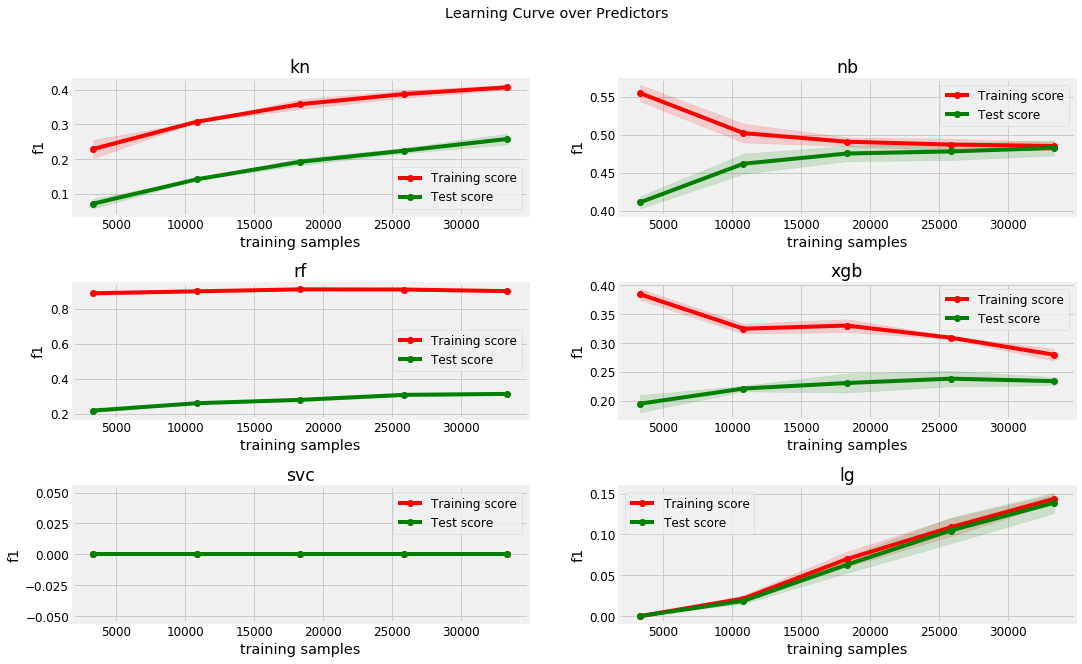

In [40]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# Learning Curve
def plot_learning_curve(predictor, X, y, name_param, name_pred, scoring='accuracy', cv=3):
    train_sizes, train_scores, test_scores = learning_curve(predictor, X, y, scoring=scoring, cv=cv)
    call_plot(train_sizes, train_scores, test_scores, name_pred, name_param, scoring)
    

def plot_multiple_learning_curve(preds, X, y, title='', figsize=(13, 5), names=[], scoring='accuracy', cv=3):
    '''
    Calling learning curve plots for multiple predictors.
    Learning curves are good indicators of overfitting or underfitting.
    
    '''
    n_pred = len(preds)
    
    train_scores = {}
    test_scores = {}
    
    for i, pred in enumerate(preds):
        train_sizes, train_scores[names[i]], test_scores[names[i]] = learning_curve(pred, X, y, 
                                                                                    scoring=scoring, cv=cv)
    

    plt.rcParams['font.size'] = 12
    
    n_col = 2
    n_row = int(np.ceil(n_pred/2)) 
    does_last_exist = bool(n_pred%2) 
    
    fig, axs = plt.subplots(n_row, n_col, figsize=figsize, sharex=False, sharey=False)
    if does_last_exist:
        fig.delaxes(axs[n_row-1, 1])
    
    axs = axs.ravel()
    axs = axs[:-1] if does_last_exist else axs
    
    fig.suptitle(title)
    plt.subplots_adjust(hspace=0.5)
    
    for i, ax in enumerate(axs):
        mean_train_scores = np.mean(train_scores[names[i]], axis=1)
        mean_test_scores = np.mean(test_scores[names[i]], axis=1)
        std_train_scores = np.std(train_scores[names[i]], axis=1)
        std_test_scores = np.std(test_scores[names[i]], axis=1)
        
        ax.plot(train_sizes, mean_train_scores, 'o-', color='r',
                  label='Training score')
        ax.plot(train_sizes, mean_test_scores, 'o-', color='g',
                  label='Test score')
        ax.fill_between(train_sizes, mean_train_scores - std_train_scores,
                          mean_train_scores + std_train_scores, alpha=0.15, color='r')
        ax.fill_between(train_sizes, mean_test_scores - std_test_scores,
                          mean_test_scores + std_test_scores, alpha=0.15, color='g')
        ax.legend(loc='best')
        ax.set_xlabel('training samples')
        ax.set_ylabel(scoring)
        ax.set_title(names[i])
    

predictors = [KNeighborsClassifier(), GaussianNB(), RandomForestClassifier(), 
              XGBClassifier(), SVC(decision_function_shape='ovo'), LogisticRegression()]
pred_names = ['kn', 'nb', 'rf', 'xgb', 'svc', 'lg']

plot_multiple_learning_curve(predictors, short_X, short_y, figsize=(16, 10), 
                              title='Learning Curve over Predictors', names=pred_names, scoring='f1', cv=3)

### Findings

- These plots are very interesting. I observe strong overfitting in SVC, RF and KNN. So far, naive bayes classifier shows the best performance out of all the classifiers.
- Despite its powerful performance in most cases, xgboosting underfits the data with low training score. Adding more data to xgboosting will hardly increase the performance.


### Based on the plots above, regularized random forest and naive bayes classifier seem to be the most promising for the best performance.

<br>

## 3 Hyper-parameter Tuning 

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(chi2_vec_cat, labels, 
                                                    test_size=0.2, stratify=labels, random_state=42)
kfold = StratifiedKFold(n_splits=3, random_state=42)

In [71]:
# Hyperparameter grid
rf_param_grid = {
    'n_estimators': np.linspace(10, 80, num=5).astype(int),
    'max_depth': [None] + list(np.linspace(1, 10, num=3).astype(int)),
    'max_features': ['auto', 'log2', None],
    'min_samples_split': [100, 0.1, 0.3],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier()
rf_rs = RandomizedSearchCV(rf, rf_param_grid, n_jobs = -1,
                        scoring = 'f1', cv = kfold, 
                        n_iter = 20, verbose = 3, error_score=np.nan)

rf_rs.fit(X_train.toarray(), y_train)

best_rf = rf_rs.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 19.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 61.7min finished


In [81]:
print('The best parameter set from 20 iterations of random search')
for key, val in rf_rs.best_params_.items():
    print('{:20} : {}'.format(key, val))

The best parameter set from 20 iterations of random search
n_estimators         : 45
min_samples_split    : 100
max_features         : auto
max_depth            : None
class_weight         : balanced
bootstrap            : True


In [82]:
test_val = cross_validate(best_rf, X_train.toarray(), y_train, 
                          scoring=['accuracy', 'precision', 'recall', 'f1'], cv=kfold)
    
accuracy = round(test_val['test_accuracy'].mean(), 3)
precision = round(test_val['test_precision'].mean(), 3)
recall = round(test_val['test_recall'].mean(), 3)
fscore = round(test_val['test_f1'].mean(), 3)
    
print("RF", "- accuracy: {0}, precision: {1}, recall: {2}, fscore: {3}"\
          .format(accuracy, precision, recall, fscore))

RF - accuracy: 0.899, precision: 0.344, recall: 0.702, fscore: 0.462


In [ ]:
import pickle
with open('rf_rs.pkl', 'wb') as f:
    pickle.dump(rf_rs, f)

In [54]:
# Initial Modeling
# Stratified Cross-validation
kfold = StratifiedKFold(n_splits=3, random_state=42)
nb = GaussianNB()
test_val = cross_validate(nb, X_train.toarray(), y_train, 
                          scoring=['accuracy', 'precision', 'recall', 'f1'], cv=kfold)
    
accuracy = round(test_val['test_accuracy'].mean(), 3)
precision = round(test_val['test_precision'].mean(), 3)
recall = round(test_val['test_recall'].mean(), 3)
fscore = round(test_val['test_f1'].mean(), 3)
    
print("NB", "- accuracy: {0}, precision: {1}, recall: {2}, fscore: {3}"\
          .format(accuracy, precision, recall, fscore))

NB - accuracy: 0.927, precision: 0.427, recall: 0.546, fscore: 0.479


<br>

# Evaluation

## 1. ROC Curve

In [103]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(clf, X_train, X_test, y_train, y_test, clf_name='nb'):
    try:
        prob_test = clf.predict_proba(X_test)[:, 1]
        prob_train = clf.predict_proba(X_train)[:, 1]
    except:
        prob_test = clf.decision_function(X_test)
        prob_train = clf.decision_function(X_train)

    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, prob_test)
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, prob_train)

    auc_test = auc(fpr_test, tpr_test)
    auc_train = auc(fpr_train, tpr_train)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

    ax1.plot(fpr_train, tpr_train, color='darkorange', lw=1, label='Trin ROC curve (area = %0.2f)' % auc_train)
    ax1.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
    ax1.set_xlim([-0.1, 1.0])
    ax1.set_ylim([-0.1, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Train ROC for {}'.format(clf_name))
    ax1.legend(loc="lower right")

    ax2.plot(fpr_test, tpr_test, color='darkorange', lw=1, label='Test ROC curve (area = %0.2f)' % auc_test)
    ax2.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
    ax2.set_xlim([-0.1, 1.0])
    ax2.set_ylim([-0.1, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Test ROC of {}'.format(clf_name))
    ax2.legend(loc="lower right")

    plt.show()

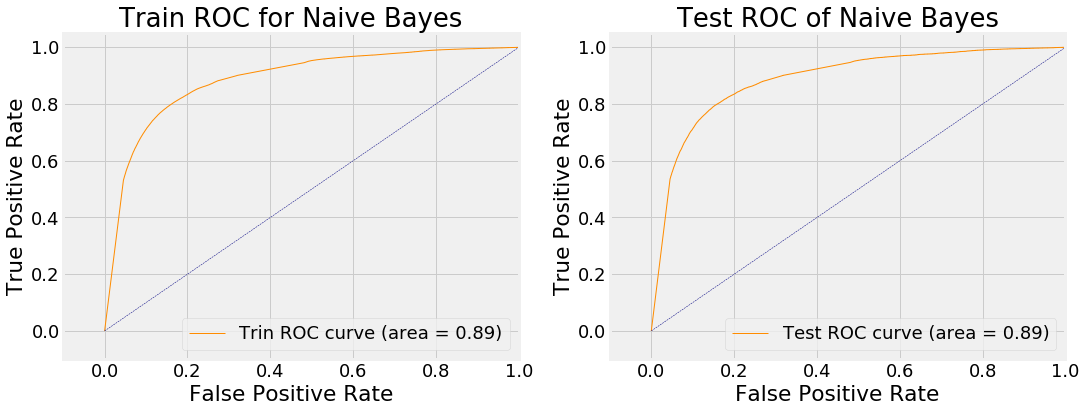

In [108]:
#nb.fit(X_train.toarray(), y_train)
plot_roc_curve(nb, X_train.toarray(), X_test.toarray(), y_train, y_test, 'Naive Bayes')

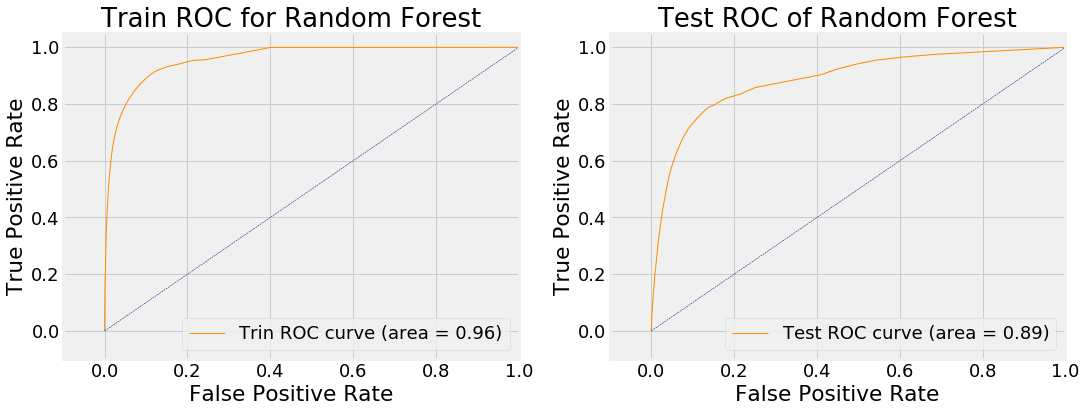

In [107]:
#best_rf.fit(X_train, y_train)
plot_roc_curve(best_rf, X_train, X_test, y_train, y_test, 'Random Forest')

<br>

## 2. Confusion Matrix and Precision & Recall

Accuracy : 0.927104986123074
Classification Report
              precision    recall  f1-score   support

           0     0.9697    0.9521    0.9608    245063
           1     0.4301    0.5484    0.4821     16162

   micro avg     0.9271    0.9271    0.9271    261225
   macro avg     0.6999    0.7503    0.7215    261225
weighted avg     0.9363    0.9271    0.9312    261225



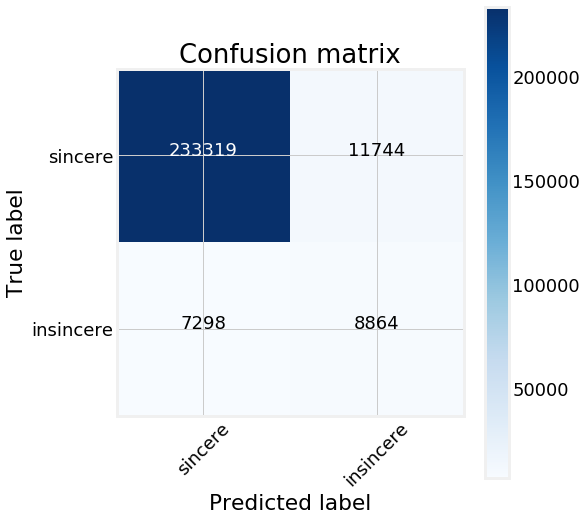

In [106]:
# Full-Report
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
def plot_confusion_mat(cm, classes, cmap=plt.cm.Blues):
    title='Confusion matrix'
    
    plt.rcParams['font.size'] = 18
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def full_report(model, x, y_true, classes):
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict(x)
    y_true = y_true

    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true, y_pred)))
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true, y_pred, digits=4))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    
    #print(cnf_matrix)
    plot_confusion_mat(cnf_matrix, classes=classes)  

full_report(nb, X_test.toarray(), y_test, ['sincere', 'insincere'])

<br>

# Conclusion

- The last result is a tie match between random forest and naive bayes. However, there is still a overfitting behavior to random forest with far highter training performance than that of naive bayes. This indicates adding more training samples is likely to improve random forest classifier while it is unlikely to improve naive bayes.
- I achieved around 47% of f1-score and 0.89 AUC for the binary classification from both naive bayes and regualized random forest.